# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

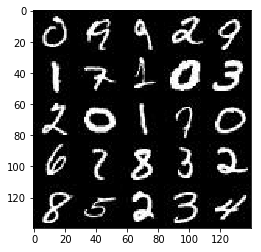

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

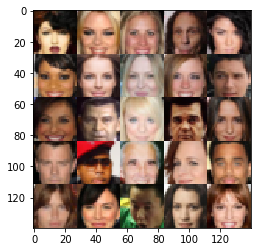

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    #Variable 노드는 다른 언어의 Variable과 달리, 실행 시 텐서플로우가 변경시키는 값이라고 생각하면 이해하기 편하다.(학습하는 과정에서 변경시킨다.)
    #tf.placeholder()는 입력 데이터를 만들 때 주로 사용한다. (실제 훈련 예제를 제공하는 변수) - 초기값을 지정할 필요 없다. (모델 입력시 변경되지 않을 데이터)
    #tf.Variable()은 데이터의 상태를 저장할 때 주로 사용한다. (가중치나 편향 등의 학습 가능한 변수) - 초기값을 지정해야 한다. (학습 되는 데이터)
    #http://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Leaky ReLU

In [6]:
def leaky_relu(x, alpha=0.01): #leaky_relu. x는 텐서. 
        return tf.maximum(alpha * x, x)
        #Leaky ReLU는 마이너스 입력일 경우 0이 아닌 입력 절대값에 비례한 작은 값을 리턴한다.
        #Leaky ReLU를 지원하지 않기 때문에 직접 만들어야 한다. 음수 값 입력에선 alpha *x, 양수 값 입력에선 x 반환

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse): #공유 변수
    #tf.variable_scope : 공유 변수. 공유 변수를 사용하지 않으면 학습된 변수가 아닌 계속해서 새로운 변수를 생성하게 된다.
    #tf.variable_scope에 reuse 키워드를 사용하여 그래프를 다시 작성하는 경우 새 변수를 작성하는 대신 변수를 재사용하도록 지시 할 수 있다.
    
        # Input layer is 28x28x3 : 28x28 dimensional images. RGB
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same') #CNN
        relu1 = leaky_relu(x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        relu2 = tf.nn.dropout(relu2, 0.7)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
#         bn3 = tf.layers.batch_normalization(x3, training=True) #판별기에 너무 많은 batch_normalization하다 보면 오버피팅될 수 있다.
        #판별기는 적절한 오류를 내야 하고(생성 이미지를 진짜로 판단), 생성기는 그 반대.
        relu3 = leaky_relu(x3)
        relu3 = tf.nn.dropout(relu3, 0.7)
        # 4x4x256
        
        #tf.contrib.layers.xavier_initializer()를 사용해서 초기값을 정확하게 설정해 준다.
        
        #tf.layers.batch_normalization : 배치 사용 (인풋). training는 optional. 현재 학습인지 테스트인지 bool로.
        #GAN 정확도를 높이기 위해 Batch Normalization를 사용한다. discriminator가 한 번에 여러 샘플을 보도록 Batch Normalization 사용.
        ##Batch Normalization : 각 layer의 input을 normailze하여, distribution을 일정하게 유지시키려는 시도.
        #https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        
        #tf.layers.conv2d : CNN 생성. (inputs, filters, kernel_size)
        #https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
        #kernel_initializer=tf.contrib.layers.xavier_initializer()를 사용해 커널을 초기화하면 더 정확한 결과를 얻을 수 있다.
        
        #tf.nn.dropout : 드랍 아웃 적용. (input, keep_prob)
        #https://www.tensorflow.org/api_docs/python/tf/nn/dropout

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256)) #FC input으로 사용하기 위해 reshape
        logits = tf.layers.dense(flat, 1) #FC
        out = tf.sigmoid(logits) #활성함수 sigmoid
        
        #tf.contrib.layers.flatten()로 평탄화할 수도 있다.
        #https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten
        
        #tf.layers.dense : Functional interface for the densely-connected layer.
        #tf.layers.dense를 사용하면 간단하게 신경망을 만들 수 있다. 파라미터는 (인풋, 출력 차원(아웃풋 사이즈)). 나머지는 모두 optional. Relu를 활성화함수로 FC
        #https://www.tensorflow.org/api_docs/python/tf/layers/dense
        
        #이전 mnist에서 만든 discriminator 비슷하지만 더 깊고, Batch Normalization 사용

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse= not is_train): #공유 변수
    #tf.variable_scope : 공유 변수. 공유 변수를 사용하지 않으면 학습된 변수가 아닌 계속해서 새로운 변수를 생성하게 된다.
    #tf.variable_scope에 reuse 키워드를 사용하여 그래프를 다시 작성하는 경우 새 변수를 작성하는 대신 변수를 재사용하도록 지시 할 수 있다.
    
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512) #인풋: 노이즈 벡터, 출력 사이즈 : 7*7*512 #FC
        #tf.contrib.layers.flatten()로 평탄화할 수도 있다.
        #https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) #CNN 인풋에 맞도록 reshape
        x1 = tf.layers.batch_normalization(x1, training=is_train) #Batch Normalization
        x1 = leaky_relu(x1) #Leaky ReLU activation. 활성 함수로 leaky ReLU 사용.
        x1 = tf.nn.dropout(x1, 0.5)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        #inputs, filters, kernel_size
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        x2 = tf.nn.dropout(x2, 0.5)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        x3 = tf.nn.dropout(x3, 0.5)
        #14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = leaky_relu(x4)
        x4 = tf.nn.dropout(x4, 0.5)
        # 28x28x64 now
        
        #tf.layers.dense : Functional interface for the densely-connected layer.
        #tf.layers.dense를 사용하면 간단하게 신경망을 만들 수 있다. 파라미터는 (인풋, 출력 차원(아웃풋 사이즈)). 나머지는 모두 optional. Relu를 활성화함수로 FC
        #https://www.tensorflow.org/api_docs/python/tf/layers/dense
        
        #tf.layers.batch_normalization : 배치 사용 (인풋). training는 optional. 현재 학습인지 테스트인지 bool로.
        #GAN 정확도를 높이기 위해 Batch Normalization를 사용한다. discriminator가 한 번에 여러 샘플을 보도록 Batch Normalization 사용.
        ##Batch Normalization : 각 layer의 input을 normailze하여, distribution을 일정하게 유지시키려는 시도.
        #https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization
        
        #tf.layers.conv2d_transpose : 전치된 CNN 생성. (일반 CNN과 반대) (inputs, filters, kernel_size)
        #https://www.tensorflow.org/api_docs/python/tf/layers/conv2d_transpose
        #kernel_initializer=tf.contrib.layers.xavier_initializer()를 사용해 커널을 초기화하면 더 정확한 결과를 얻을 수 있다.
        
        #tf.nn.dropout : 드랍 아웃 적용. (input, keep_prob)
        #https://www.tensorflow.org/api_docs/python/tf/nn/dropout
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same') #CNN
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits) #마지막 활성 함수는 tanh. 28x28 (image 크기)
        #tanh는 -1과 1사이의 값을 리턴 cf. sigmoid : 0 ~ 1사이의 값
        
        #이전 mnist에서 만든 generator와 비슷하지만 더 깊고, Batch Normalization 사용
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth=0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True) #이미지 생성
    d_model_real, d_logits_real = discriminator(input_real, reuse=False) #실제 이미지
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True) #생성된 이미지

    d_loss_real = tf.reduce_mean( #식별기 실제 이미지 손실
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    #1로 판별해야 하므로 tf.one_like 사용 : 1을 출력하기를 원함
    #Discriminator의 일반화를 돕기 위해 매개 변수 smooth를 사용하여 레이블을 1.0에서 0.9로 약간 줄인다. 
    #일반적으로 성능 향상을 위해 Discriminator와 함께 사용되는 label smoothing이라고 한다.
    
    d_loss_fake = tf.reduce_mean( #식별기 생성 이미지 손실
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    #0으로 판별해야 하므로 tf.zeros_like 사용 : 0을 출력하기를 원함 (Generator로 생성된 것을 가짜로 판별하는 것이 Discriminator의 목적)
    #d_loss_real과 비슷하지만 smoothing이 적용되지 않았다
    
    g_loss = tf.reduce_mean( #생성기 손실
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    #1로 판별해야 하므로 tf.one_like 사용 : 1을 출력하기를 원함 (Discriminator를 속이는 것이 Generator의 목적)

    d_loss = d_loss_real + d_loss_fake #식별기의 손실은 실제 이미지 손실과 생성된 이미지 손실의 합
    #Discriminator의 총 손실은 실제 데이터 손실과 생성 데이터 손실의 합

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables() #학습된 변수들을 불러 온다. 
    #trainable=True로 만든 모든 변수 반환
    #https://www.tensorflow.org/api_docs/python/tf/trainable_variables
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")] #generator에서 만든 변수 뽑아내 저장
    g_vars = [var for var in t_vars if var.name.startswith("generator")] #discriminator에서 만든 변수 뽑아내 저장

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): #의존성 지정. 컨텍스트 정의 전 실행되거나 계산되어야 할 목록
        #'tf.control_dependencies'문맥은 TensorFlow에게 'tf.nn.batch_normalization'계층을 계산하기 전에 
        #'train_mean'과 'train_variance'를 계산해야한다고 알려준다. 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        #Adam으로 최적화. var_list로 넘어온 변수들만 최적화한다.

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #data_shape[0] : count
    #data_shape[1] : width
    #data_shape[2] : height
    #data_shape[3] : channels
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) #초기화
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2 # normalization (-0.5 ~ 0.5 사이의 batch_images를 -1.0 ~ 1.0으로 스케일링)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)) #생성기에 노이즈 추가. 랜덤 노이즈에서 이미지 생성
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                #discriminator 손실이 0이 되지 않도록 제네레이터 최적화를 두 번 실행할 수도 있다.
                                
                if steps % 10 == 0: #10번 마다 출력 
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0: #100번 마다 이미지 출력             
                    show_generator_output(sess, n_images=25, input_z=input_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)
                
                steps += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 0.8625


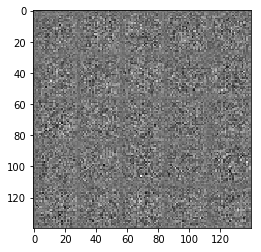

Epoch 1/2... Discriminator Loss: 0.8219... Generator Loss: 1.4487
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 1.3670
Epoch 1/2... Discriminator Loss: 0.6513... Generator Loss: 1.8287
Epoch 1/2... Discriminator Loss: 0.6797... Generator Loss: 1.7499
Epoch 1/2... Discriminator Loss: 0.6969... Generator Loss: 2.9857
Epoch 1/2... Discriminator Loss: 0.5305... Generator Loss: 2.7527
Epoch 1/2... Discriminator Loss: 0.7780... Generator Loss: 1.8239
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 2.4012
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 2.0788
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 1.4994


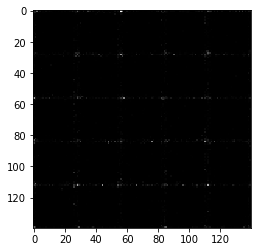

Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 1.9849
Epoch 1/2... Discriminator Loss: 0.8082... Generator Loss: 2.0744
Epoch 1/2... Discriminator Loss: 0.8824... Generator Loss: 2.1981
Epoch 1/2... Discriminator Loss: 0.8899... Generator Loss: 1.6208
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 1.8010
Epoch 1/2... Discriminator Loss: 1.0153... Generator Loss: 2.0370
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.3601
Epoch 1/2... Discriminator Loss: 1.1464... Generator Loss: 0.8693
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 1.4927
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 1.1340


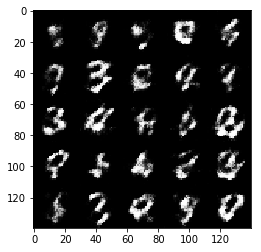

Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 1.6382
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 1.2228
Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 1.6291
Epoch 1/2... Discriminator Loss: 1.0169... Generator Loss: 1.8278
Epoch 1/2... Discriminator Loss: 0.9599... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 1.0104... Generator Loss: 1.4923
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 1.6906
Epoch 1/2... Discriminator Loss: 1.0471... Generator Loss: 1.0810
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.9970


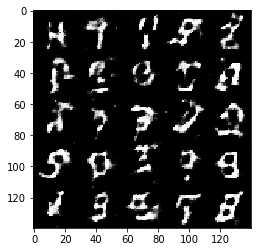

Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 1.6705
Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 1.3410
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.8944
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 1.3111
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.7405
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 1.6681
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 1.6274
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.7223


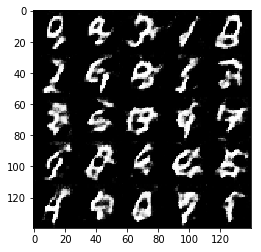

Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 1.1215
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 1.2573
Epoch 1/2... Discriminator Loss: 1.0890... Generator Loss: 1.3682
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 1.2966
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 1.6553
Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.8111
Epoch 1/2... Discriminator Loss: 1.1063... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 0.9324... Generator Loss: 1.2437
Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 1.1193


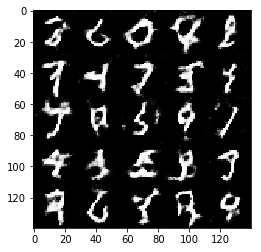

Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 1.6548
Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 1.0070
Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 1.3467
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 1.1485
Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 1.0394
Epoch 1/2... Discriminator Loss: 1.0098... Generator Loss: 1.2436
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.0167
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 1.4384
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 1.2024


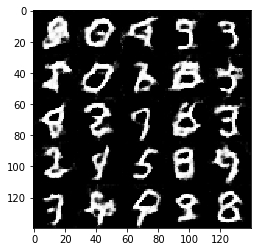

Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.1257
Epoch 1/2... Discriminator Loss: 1.0806... Generator Loss: 1.1691
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 1.2725
Epoch 1/2... Discriminator Loss: 1.0821... Generator Loss: 1.1140
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 1.4299
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.2128
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 1.0898
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.3429
Epoch 1/2... Discriminator Loss: 0.9961... Generator Loss: 1.5599
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.2207


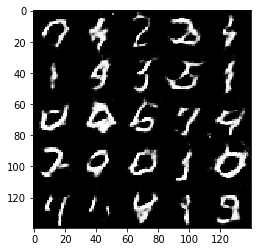

Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 1.3305
Epoch 1/2... Discriminator Loss: 0.9949... Generator Loss: 1.1197
Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 0.9851... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 1.4654
Epoch 1/2... Discriminator Loss: 1.0453... Generator Loss: 1.1410
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 1.4332
Epoch 1/2... Discriminator Loss: 1.1373... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 1.1524... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 1.3425


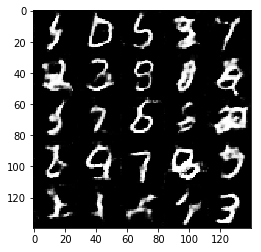

Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.0563
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 1.3912
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 1.4027
Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 1.6045
Epoch 1/2... Discriminator Loss: 1.0925... Generator Loss: 1.4171
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 1.0510... Generator Loss: 1.6022


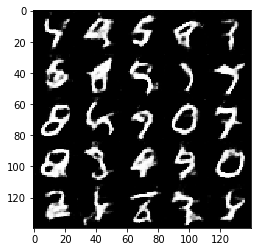

Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 1.5509
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 0.7846
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 1.0015
Epoch 2/2... Discriminator Loss: 1.1218... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.9901... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 1.5037
Epoch 2/2... Discriminator Loss: 1.0392... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 1.2980
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 1.1471
Epoch 2/2... Discriminator Loss: 1.0377... Generator Loss: 1.1875


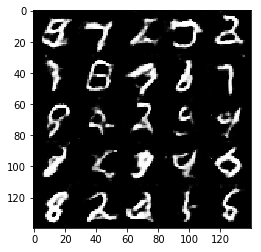

Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 1.4513
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 0.7987
Epoch 2/2... Discriminator Loss: 0.9521... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.1213
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 1.4387
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 1.2871
Epoch 2/2... Discriminator Loss: 1.0593... Generator Loss: 1.4042
Epoch 2/2... Discriminator Loss: 1.0521... Generator Loss: 1.2822
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 1.3727


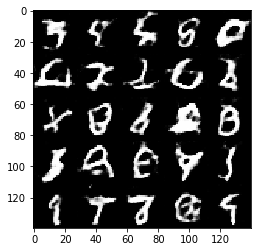

Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 1.1230... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 1.0164
Epoch 2/2... Discriminator Loss: 0.9712... Generator Loss: 1.5500
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 1.3056
Epoch 2/2... Discriminator Loss: 1.0541... Generator Loss: 1.0403
Epoch 2/2... Discriminator Loss: 1.1060... Generator Loss: 1.8602
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 1.2106
Epoch 2/2... Discriminator Loss: 1.1007... Generator Loss: 1.1050
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.5480


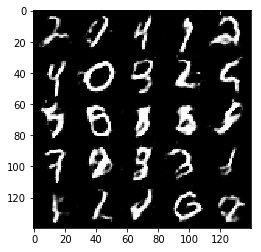

Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 1.6319
Epoch 2/2... Discriminator Loss: 1.0591... Generator Loss: 1.3239
Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 1.1597
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 1.7129
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 1.6971
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.3949
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 1.5496
Epoch 2/2... Discriminator Loss: 0.9577... Generator Loss: 1.3958
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.4907


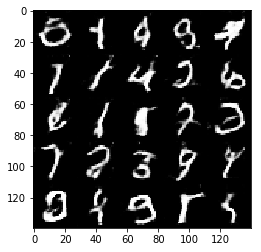

Epoch 2/2... Discriminator Loss: 1.0486... Generator Loss: 0.9344
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 1.0796
Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 1.5720
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.3089
Epoch 2/2... Discriminator Loss: 0.9956... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 0.9536... Generator Loss: 1.5408
Epoch 2/2... Discriminator Loss: 1.1068... Generator Loss: 1.2947
Epoch 2/2... Discriminator Loss: 1.3094... Generator Loss: 2.0313
Epoch 2/2... Discriminator Loss: 1.1327... Generator Loss: 1.5376
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 1.3971


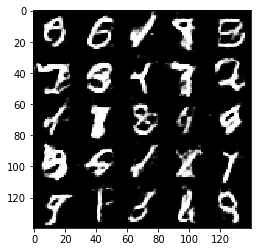

Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 0.9406
Epoch 2/2... Discriminator Loss: 1.1006... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 0.9764... Generator Loss: 1.3971
Epoch 2/2... Discriminator Loss: 1.0035... Generator Loss: 1.1371
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.1003
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 1.4784
Epoch 2/2... Discriminator Loss: 1.0767... Generator Loss: 1.0444
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 1.3334
Epoch 2/2... Discriminator Loss: 0.9574... Generator Loss: 1.2988
Epoch 2/2... Discriminator Loss: 1.0498... Generator Loss: 1.5000


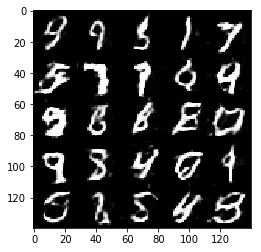

Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 1.0654... Generator Loss: 1.4749
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.0976
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 1.6351
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 1.2787
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.4431
Epoch 2/2... Discriminator Loss: 1.0484... Generator Loss: 1.0887
Epoch 2/2... Discriminator Loss: 1.0059... Generator Loss: 1.1280


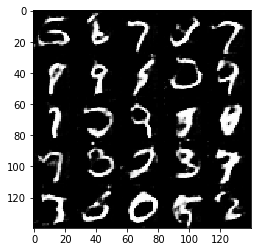

Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 1.3116
Epoch 2/2... Discriminator Loss: 1.1059... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 1.1378
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 1.0693... Generator Loss: 1.0861
Epoch 2/2... Discriminator Loss: 1.0720... Generator Loss: 1.3909
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 1.1638
Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 1.3017
Epoch 2/2... Discriminator Loss: 1.0848... Generator Loss: 1.3370
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 1.5736


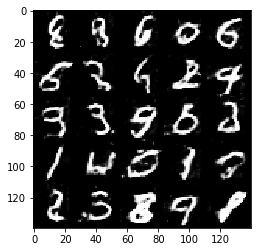

Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 1.0656
Epoch 2/2... Discriminator Loss: 1.2184... Generator Loss: 0.9161
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 1.0582
Epoch 2/2... Discriminator Loss: 1.2064... Generator Loss: 1.7744
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 1.3355
Epoch 2/2... Discriminator Loss: 1.0387... Generator Loss: 1.3832
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 1.4327
Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 1.6160


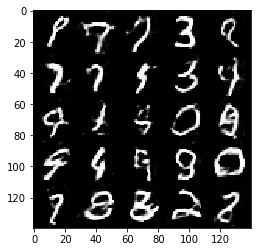

Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 1.2914
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.3163
Epoch 2/2... Discriminator Loss: 1.0421... Generator Loss: 1.1237
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 1.3581
Epoch 2/2... Discriminator Loss: 1.1298... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 1.3916


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.8587


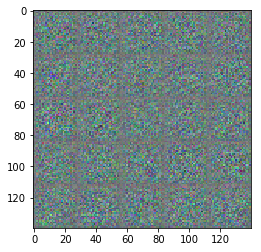

Epoch 1/1... Discriminator Loss: 0.6395... Generator Loss: 2.2336
Epoch 1/1... Discriminator Loss: 0.4977... Generator Loss: 2.7516
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 3.3581
Epoch 1/1... Discriminator Loss: 0.4537... Generator Loss: 3.5361
Epoch 1/1... Discriminator Loss: 0.5115... Generator Loss: 2.9286
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 3.2551
Epoch 1/1... Discriminator Loss: 0.5476... Generator Loss: 2.6877
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 2.3530
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 3.6866
Epoch 1/1... Discriminator Loss: 0.5178... Generator Loss: 2.5455


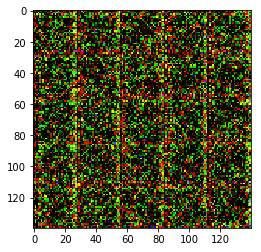

Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 3.3253
Epoch 1/1... Discriminator Loss: 0.5831... Generator Loss: 4.0553
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 2.5764
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 2.8536
Epoch 1/1... Discriminator Loss: 0.5251... Generator Loss: 2.3785
Epoch 1/1... Discriminator Loss: 0.6199... Generator Loss: 3.8380
Epoch 1/1... Discriminator Loss: 0.5086... Generator Loss: 3.1312
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 3.0183
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 3.1151
Epoch 1/1... Discriminator Loss: 0.5048... Generator Loss: 3.7034


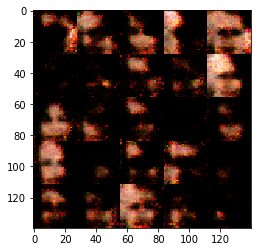

Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 2.1880
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 3.9682
Epoch 1/1... Discriminator Loss: 0.5237... Generator Loss: 2.5770
Epoch 1/1... Discriminator Loss: 0.5541... Generator Loss: 3.2676
Epoch 1/1... Discriminator Loss: 0.5359... Generator Loss: 3.1744
Epoch 1/1... Discriminator Loss: 0.6059... Generator Loss: 2.1928
Epoch 1/1... Discriminator Loss: 0.5555... Generator Loss: 2.2939
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 2.9829
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.9359


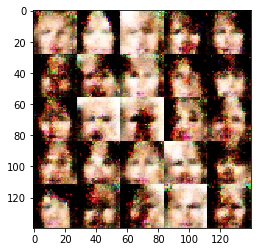

Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 3.3285
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.7163
Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 2.1901
Epoch 1/1... Discriminator Loss: 0.6183... Generator Loss: 2.5992
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.0841
Epoch 1/1... Discriminator Loss: 0.6514... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 0.6727... Generator Loss: 2.5802
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 2.3289
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.3291
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.6125


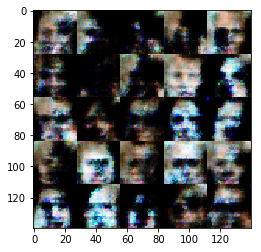

Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 2.1744
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 2.4455
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 1.9060
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 2.6744
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.5455
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 2.6622
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.8642
Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.9690
Epoch 1/1... Discriminator Loss: 0.8966... Generator Loss: 2.1104


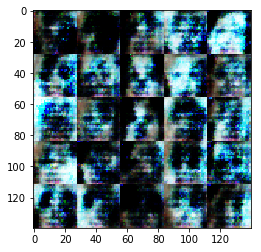

Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 2.0024
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.4477
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.6388
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.6119
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.7105
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 2.0549


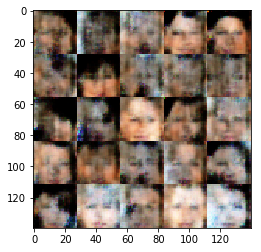

Epoch 1/1... Discriminator Loss: 1.0613... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 1.0244... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.5405
Epoch 1/1... Discriminator Loss: 0.8633... Generator Loss: 1.8165
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 0.8282... Generator Loss: 2.0687
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 0.8730... Generator Loss: 1.5955
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.5342


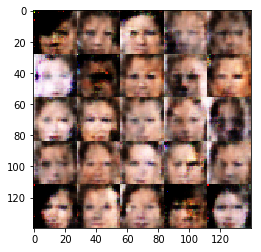

Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 0.8425... Generator Loss: 1.9335
Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.5399
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 1.4375
Epoch 1/1... Discriminator Loss: 1.0026... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 1.0688... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.0466... Generator Loss: 1.2839
Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.6146
Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.6770


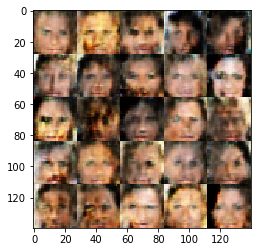

Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.2667
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.6976
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.0465
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.5508
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.3949
Epoch 1/1... Discriminator Loss: 0.8063... Generator Loss: 1.9705
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 1.0597... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.8940


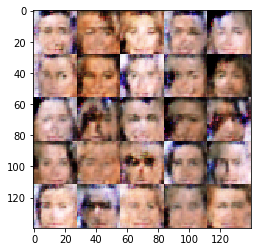

Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 1.5892
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.4103
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.4259
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 0.9285... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.5001
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 1.2132
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.6654
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.6373


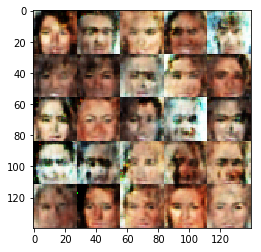

Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.1201
Epoch 1/1... Discriminator Loss: 1.0134... Generator Loss: 1.3664
Epoch 1/1... Discriminator Loss: 1.0823... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 1.4222
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 1.2486
Epoch 1/1... Discriminator Loss: 0.9888... Generator Loss: 1.5810
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 1.3793
Epoch 1/1... Discriminator Loss: 0.9630... Generator Loss: 1.4301
Epoch 1/1... Discriminator Loss: 0.9903... Generator Loss: 1.4262


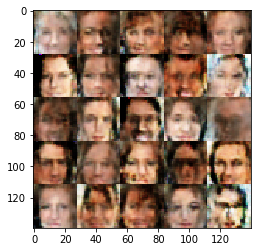

Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.4255
Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 1.5683
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.2344
Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 1.3903
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 1.6555
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.3400
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9992


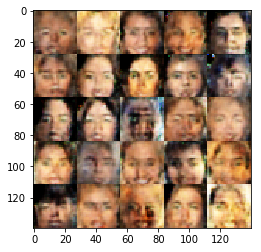

Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 1.0368... Generator Loss: 1.3483
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.3223
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.2165
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 1.4538


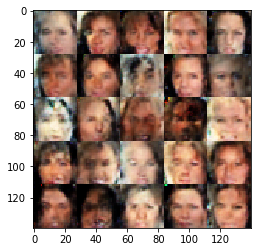

Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 1.3614
Epoch 1/1... Discriminator Loss: 0.9443... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.4395
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 1.4720
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.0059... Generator Loss: 1.4941
Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.2154
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.0431


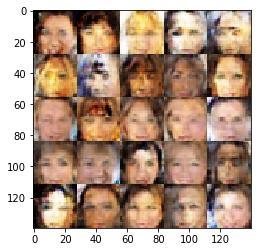

Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 1.1690
Epoch 1/1... Discriminator Loss: 0.9540... Generator Loss: 1.3660
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.4228
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.1924


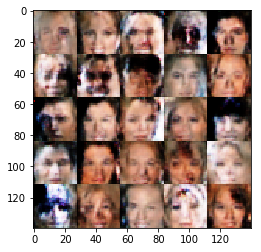

Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.2840
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.1552... Generator Loss: 1.2421
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 1.4054


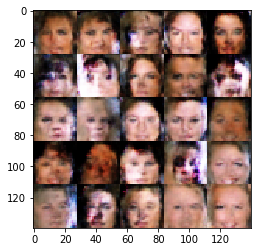

Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.0836
Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.4370
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.4164
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.1048... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 1.2291


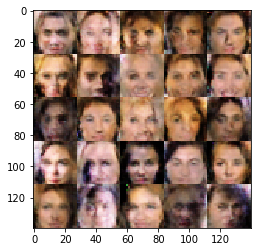

Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 1.1110
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.3125
Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.3105
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 1.3918
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.1776


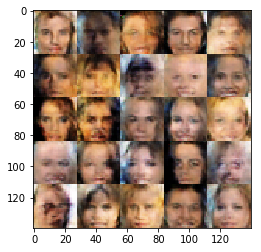

Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.2685
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 1.3314
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 1.1915
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 1.1666... Generator Loss: 1.1707
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.3130
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.3097
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.2388
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.1147


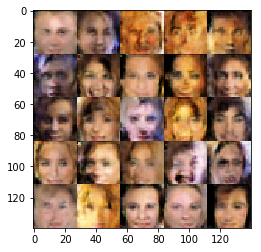

Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.0154... Generator Loss: 1.2846
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.1225... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.2935
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1324


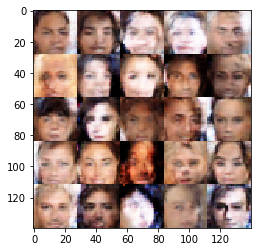

Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.1006
Epoch 1/1... Discriminator Loss: 1.1712... Generator Loss: 1.2764
Epoch 1/1... Discriminator Loss: 1.0586... Generator Loss: 1.2201
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.1617
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 1.0963
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 1.1693


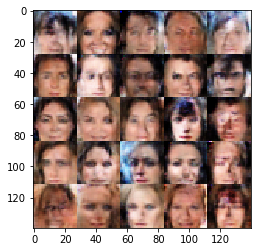

Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.2204
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.0696... Generator Loss: 1.2965
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.1458... Generator Loss: 1.1509
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 1.1374
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.3192


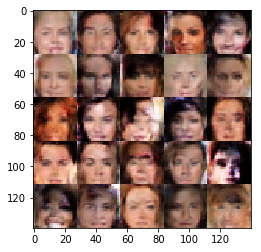

Epoch 1/1... Discriminator Loss: 1.1418... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.0874... Generator Loss: 1.1723
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.2297
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.2188
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.1299
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0995


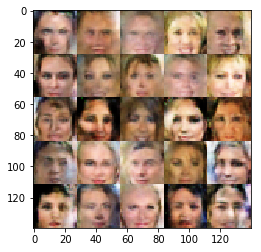

Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.0638
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.2785
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.9693
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.1474
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.0249


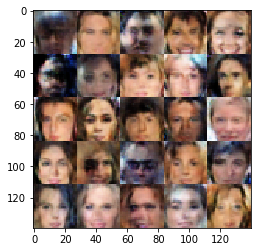

Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.0007
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 1.1419
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 1.2040


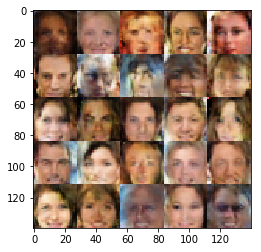

Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.2147
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 1.1131
Epoch 1/1... Discriminator Loss: 1.1254... Generator Loss: 1.1549
Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.0349
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 1.1724
Epoch 1/1... Discriminator Loss: 1.2220... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.1892


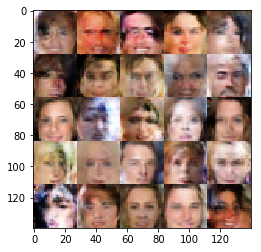

Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.2273
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.2155
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.1165
Epoch 1/1... Discriminator Loss: 1.1667... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.1680... Generator Loss: 1.1468
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.9872


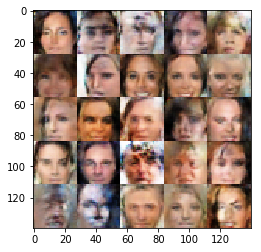

Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.0512
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 1.2057
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 1.0607
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.9922
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 1.1106
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.9938
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 1.0305


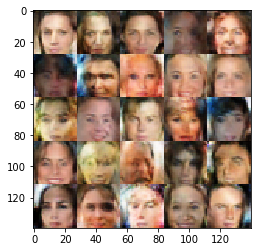

Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.9686
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 1.1870
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 1.0143
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 1.0348
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 1.3684


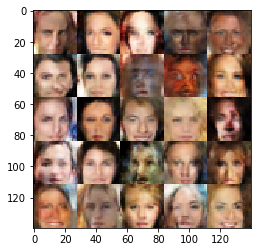

Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.0434
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 1.2063
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0803


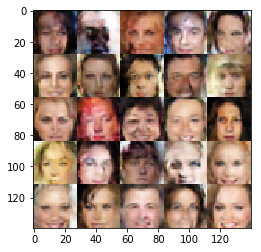

Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.9889
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.0938... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.0375


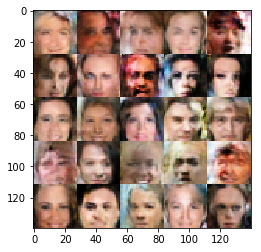

Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 1.0601
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 1.0222


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.